# Qualitative Evaluation of Model

**Goal**: using a trained model, evaluate AUC scores for classes individually

1. Load model
2. Load dataset
3. Split dataset based on label
4. Evaluate the AUC score of the model on each label
5. Generate plot AUC scores.
6. Provide two examples where the model struggled and one where it succeeded 

In [68]:
import torch
from CNN.dataset import MagnaTagATune
from CNN.model import Model
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [69]:
# Move data to appropriate device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f'Running model on device {DEVICE}')

MODEL_PATH = "../models/CNN_bs=10_lr=0.005_mom=0.99_model.pth"
model = Model(256, 256)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

Running model on device cpu


Model(
  (conv1): Conv1d(1, 32, kernel_size=(256,), stride=(256,))
  (conv2): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=same)
  (full1): Linear(in_features=256, out_features=100, bias=True)
  (full2): Linear(in_features=100, out_features=50, bias=True)
)

In [70]:
# Load the train and test datasets and create
dataset_root = os.path.join("..", "data", "MagnaTagATune")

test_labels_path = os.path.join(dataset_root, "annotations", "new_test_labels.pkl")
train_labels_path = os.path.join(dataset_root, "annotations", "new_train_labels.pkl")

samples_path = os.path.join(dataset_root, "samples")
test_dataset = MagnaTagATune(test_labels_path, samples_path)
train_dataset = MagnaTagATune(train_labels_path, samples_path)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    pin_memory=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=False,
    pin_memory=True,
)

Loading data from ../data/MagnaTagATune/annotations/new_test_labels.pkl...
Loading data from ../data/MagnaTagATune/annotations/new_train_labels.pkl...


In [71]:
all_preds = []

# No need to track gradients for validation, we're not optimizing.
with torch.no_grad():
    for _, batch, _ in test_loader:
        batch = batch.to(DEVICE)
        logits = model(batch)
        preds = logits.cpu().numpy()
        all_preds.extend(list(preds))

all_preds = torch.tensor(np.array(all_preds)).to(DEVICE)

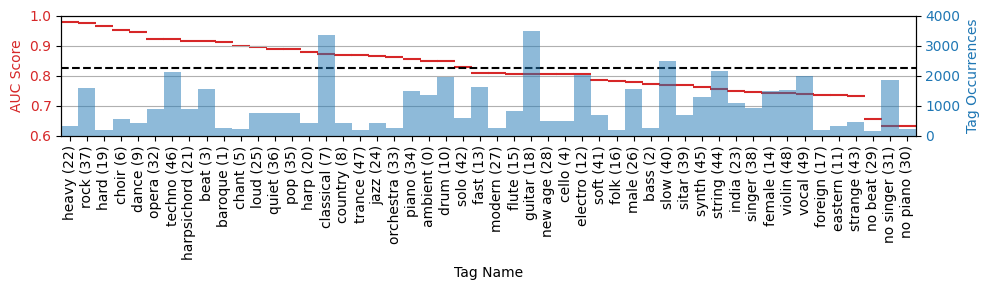

In [72]:
tag_names = {
 0: 'ambient',
 1: 'baroque',
 2: 'bass',
 3: 'beat',
 4: 'cello',
 5: 'chant',
 6: 'choir',
 7: 'classical',
 8: 'country',
 9: 'dance',
 10: 'drum',
 11: 'eastern',
 12: 'electro',
 13: 'fast',
 14: 'female',
 15: 'flute',
 16: 'folk',
 17: 'foreign',
 18: 'guitar',
 19: 'hard',
 20: 'harp',
 21: 'harpsichord',
 22: 'heavy',
 23: 'india',
 24: 'jazz',
 25: 'loud',
 26: 'male',
 27: 'modern',
 28: 'new age',
 29: 'no beat',
 30: 'no piano',
 31: 'no singer',
 32: 'opera',
 33: 'orchestra',
 34: 'piano',
 35: 'pop',
 36: 'quiet',
 37: 'rock',
 38: 'singer',
 39: 'sitar',
 40: 'slow',
 41: 'soft',
 42: 'solo',
 43: 'strange',
 44: 'string',
 45: 'synth',
 46: 'techno',
 47: 'trance',
 48: 'violin',
 49: 'vocal'
}

gts = pd.read_pickle(test_labels_path)

test_labels = []
for i in range(len(gts.iloc[:]['label'])):
    # labels.append(gts[i][2].numpy())                             # A 50D Ground Truth binary vector
    test_labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
    # model_outs.append(preds[i].cpu().numpy()) # A 50D vector that assigns probability to each class
test_labels = np.array(test_labels).astype(float)


gts = pd.read_pickle(train_labels_path)

train_labels = []
for i in range(len(gts.iloc[:]['label'])):
    # labels.append(gts[i][2].numpy())                             # A 50D Ground Truth binary vector
    train_labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
    # model_outs.append(preds[i].cpu().numpy()) # A 50D vector that assigns probability to each class
train_labels = np.array(train_labels).astype(float)
tag_auc_scores = []


tag_auc_scores = roc_auc_score(y_true=test_labels, y_score=all_preds, multi_class='ovr', average=None)
auc_score = roc_auc_score(y_true=test_labels, y_score=all_preds)

occurrences = [np.count_nonzero(train_labels[:, i]) for i in range(50)]

tags = np.array(range(50))
idx = np.argsort(tag_auc_scores)[::-1]
tag_auc_scores = tag_auc_scores[idx]
tags = tags[idx]
tag_names = list(map(lambda x: tag_names[x], tags))
for i, tag_name in enumerate(tag_names): tag_names[i] = tag_name + f' ({idx[i]})'
occurrences = np.array(occurrences)[idx]

fig, ax1 = plt.subplots(figsize=(10, 3))

color = 'tab:red'
ax1.set_xlabel('Tag Name')
ax1.set_ylabel('AUC Score', color=color)
ax1.scatter(range(50), tag_auc_scores, s=160, marker = "_", label="AUC score per tag", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(50), tag_names, rotation = 90, fontsize=10)
ax1.set_yticks(np.linspace(0.6, 1.0, 5))
ax1.axhline(y = auc_score, color="black", ls="--", label="Average AUC score") 
ax1.grid(axis = 'y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Tag Occurrences', color=color)  # we already handled the x-label with ax1
ax2.bar(range(50), occurrences, color=color, alpha=0.5, width=1.0)
ax2.set_yticks(np.linspace(4000, 0, 5))
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.margins(x=0)
plt.show()

In [73]:
heavy = 22
rock = 37
hard = 19
heavy_rock_hard = np.logical_and(test_labels[:, heavy] == 1.0, test_labels[:, rock] == 1.0)
heavy_rock_hard = np.logical_and(heavy_rock_hard, test_labels[:, hard] == 1.0)

num_heavy = np.where(test_labels[:, heavy] == 1.0)[0].shape[0]
num_rock = np.where(test_labels[:, rock] == 1.0)[0].shape[0]
num_hard = np.where(test_labels[:, hard] == 1.0)[0].shape[0]

heavy_rock_hard_idx = np.where(heavy_rock_hard)[0]
num_heavy_rock_hard = heavy_rock_hard_idx.shape[0]
print(f'There are {heavy_rock_hard_idx.shape[0]} clips that are heavy, rock and hard.')
print(f'There are {num_heavy} heavy labels. {num_heavy_rock_hard / num_heavy * 100:.2f}% of these are also in rock and hard')
print(f'There are {num_rock} rock labels. {num_heavy_rock_hard / num_rock * 100:.2f}% of these are also in heavy and hard')
print(f'There are {num_hard} hard labels. {num_heavy_rock_hard / num_hard * 100:.2f}% of these are also in rock and heavy')

i = 0
heavy_rock_hard_files = []
for file, _, _ in test_loader:
    if i in heavy_rock_hard_idx: 
        heavy_rock_hard_files.append(file[0])
        print(file[0])
    i += 1

There are 81 clips that are heavy, rock and hard.
There are 190 heavy labels. 42.63% of these are also in rock and hard
There are 564 rock labels. 14.36% of these are also in heavy and hard
There are 107 hard labels. 75.70% of these are also in rock and heavy
test/d/electric_frankenstein-sick_songs-02-ill_be_standing_on_my_own-59-88.npy
test/d/electric_frankenstein-sick_songs-06-i_wish_i_could-59-88.npy
test/d/electric_frankenstein-sick_songs-09-clockwise-59-88.npy
test/d/seismic_anamoly-afterburner-03-anthem_for_hcp-59-88.npy
test/d/seismic_anamoly-afterburner-06-nuclear_blues-146-175.npy
test/d/utopia_banished-night_of_the_black_wyvern-03-the_plague-175-204.npy
test/d/utopia_banished-night_of_the_black_wyvern-04-night_of_the_black_wyvern-204-233.npy
test/d/utopia_banished-night_of_the_black_wyvern-04-night_of_the_black_wyvern-349-378.npy
test/d/utopia_banished-night_of_the_black_wyvern-05-as_it_descends-291-320.npy
test/d/utopia_banished-night_of_the_black_wyvern-05-as_it_descends-30

In [77]:
gts = pd.read_pickle(test_labels_path)

heavy_rock_hard_auc = []
for heavy_rock_hard_file in heavy_rock_hard_files:
    test_labels = []
    for i in range(len(gts.iloc[:]['label'])):
        if gts.iloc[i]['file_path'] == heavy_rock_hard_file:
            test_labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
    test_labels = np.array(test_labels).astype(float)

    all_preds = []

    # No need to track gradients for validation, we're not optimizing.
    with torch.no_grad():
        for file, batch, labels in test_loader:
            if file[0] == heavy_rock_hard_file:
                print(file)
                batch = batch.to(DEVICE)
                logits = model(batch)
                preds = logits.cpu().numpy()
                all_preds.extend(list(preds))

    all_preds = torch.tensor(np.array(all_preds)).to(DEVICE)

    auc_score = roc_auc_score(y_true=np.squeeze(test_labels), y_score=np.squeeze(all_preds), multi_class='ovr')
    print(f'{heavy_rock_hard_file}: {auc_score:.4f}')

    heavy_rock_hard_auc.append(auc_score)



(1, 50)
torch.Size([4392, 50])
('test/d/electric_frankenstein-sick_songs-02-ill_be_standing_on_my_own-59-88.npy',)
('test/f/various_artists-south_by_southwest_compilation-14-flying_sun_palace-88-117.npy',): 0.9583
(1, 50)
torch.Size([1, 50])
('test/d/electric_frankenstein-sick_songs-06-i_wish_i_could-59-88.npy',)
('test/f/various_artists-south_by_southwest_compilation-14-flying_sun_palace-88-117.npy',): 0.9940
(1, 50)
torch.Size([1, 50])
('test/d/electric_frankenstein-sick_songs-09-clockwise-59-88.npy',)
('test/f/various_artists-south_by_southwest_compilation-14-flying_sun_palace-88-117.npy',): 0.9867
(1, 50)
torch.Size([1, 50])
('test/d/seismic_anamoly-afterburner-03-anthem_for_hcp-59-88.npy',)
('test/f/various_artists-south_by_southwest_compilation-14-flying_sun_palace-88-117.npy',): 0.9822
(1, 50)
torch.Size([1, 50])
('test/d/seismic_anamoly-afterburner-06-nuclear_blues-146-175.npy',)
('test/f/various_artists-south_by_southwest_compilation-14-flying_sun_palace-88-117.npy',): 0.9783


KeyboardInterrupt: 

In [ ]:
no_singer = 30
no_singer_idx = np.where(test_labels[:, no_singer] == 1.0)[0]
num_no_piano = no_singer_idx.shape[0]
print(f'There are {num_no_piano} no_singer labels.')

i = 0
for file, _, _ in test_loader:
    
    if i in no_singer_idx: 
        file_quoted = file[0]
        print(file_quoted)
    i += 1

all_preds = torch.tensor(np.array(all_preds)).to(DEVICE)

gts = pd.read_pickle(test_labels_path)
test_labels = []
for i in range(len(gts.iloc[:]['label'])):
    if gts.iloc[i]['file_path'] == file_quoted:
        # labels.append(gts[i][2].numpy())                             # A 50D Ground Truth binary vector
        test_labels.append(np.array(gts.iloc[i]['label']).astype(float))    # A 50D Ground Truth binary vector
        # model_outs.append(preds[i].cpu().numpy()) # A 50D vector that assigns probability to each class
test_labels = np.array(test_labels).astype(float)
auc_score = roc_auc_score(y_true=np.squeeze(test_labels), y_score=np.squeeze(all_preds), multi_class='ovr', average=None)
print(f'{auc_score:.4f}')

There are 0 no_singer labels.


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.